In [1]:
# Thoomas Goldman 2023
# DOLPHINN

import sys
import os
import matplotlib.pyplot as plt
import numpy as np

from tudatpy.kernel import constants

#Get the absolute path of the current scriptf
current_path = os.path.dirname(os.path.abspath('__file__'))
dolphinn_path = os.path.join(current_path, '..')
sys.path.append(dolphinn_path)

from DOLPHINN.pinn import DOLPHINN 
from DOLPHINN.dynamics import TwoBodyProblemRadialNonDimensionalControl
from DOLPHINN.output_layers import InitialFinalStateLayer_Radial
from DOLPHINN.training import Scheduler, Restarter
from DOLPHINN.objectives import OptimalFuel
import DOLPHINN.plotting as plotting
import DOLPHINN.utils as utils

Using backend: tensorflow
Other supported backends: tensorflow.compat.v1, pytorch, jax, paddle.
paddle supports more examples now and is recommended.


In [2]:
problem = DOLPHINN.from_solution("../Data/test/", verbose = True)

[DOLPHINN] Initializing the DOLPHINN from old solution at: ../Data/test/
[DOLPHINN][Warning] Upload of seed requested: initialisation will be overwritten by the solution
[DOLPHINN] Config file succesfully parsed. Initializing DOLPHINN with:

 ==================== Config Content ====================

----------Functions----------
dynamics                       TwoBodyProblemRadialNonDimensionalControl
input_transform                None
output_transform               InitialFinalStateLayer_Radial
objective                      OptimalFuel

----------Problem----------
initial_state                  [1.0, 0.0, 1.0]
final_state                    [1.5, 0.0, 0.816496580927726]
mu                             1.32712440042e+20
m                              100
a                              10
umax                           1
isp                            2500
length_scale                   150000000000.0
time_scale                     5042908.305393074
t0                             0
tfin

In [3]:
problem.verify()
print()
print(problem.bench.states)

[DOLPHINN] Setting up the TUDAT simulation
[DOLPHINN] Guidance is internal!
[DOLPHINN] Start Integrating
   Start epoch                330461.7167838471
   End epoch                  66422808.07936085
   Fixed step size            5000
   Initial state              [1.50020170e+11 0.00000000e+00 0.00000000e+00 7.28715684e+01
 2.97470136e+04 0.00000000e+00]

[DOLPHINN] Finished integrating in 0.004 s

{'cartesian': array([[3.30461717e+05, 1.50020170e+11, 0.00000000e+00, 0.00000000e+00,
        7.28715684e+01, 2.97470136e+04, 0.00000000e+00]])}


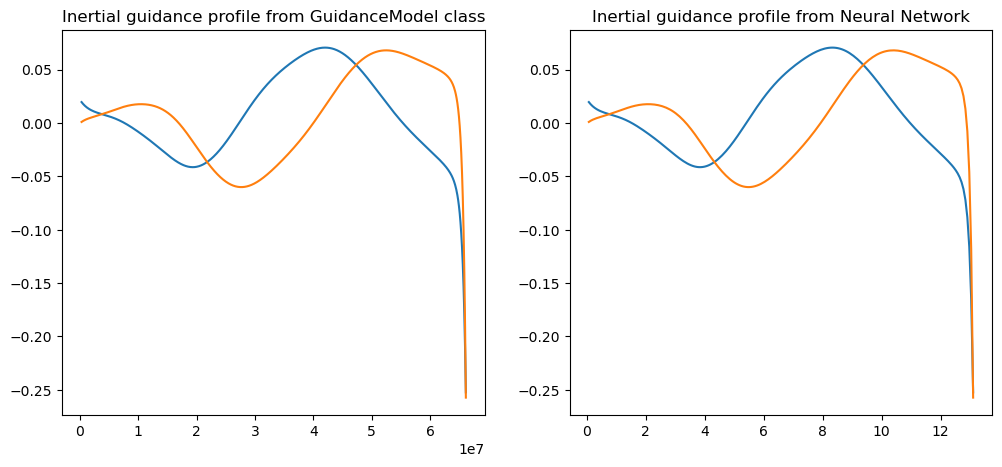

In [8]:
magnitude_function = problem.bench.GuidanceModel.getThrustMagnitude 
direction_function = problem.bench.GuidanceModel.getInertialThrustDirection

time_arr = np.linspace(problem.states['NDcartesian'][0,0]*problem.data['time_scale'], 
                       problem.states['NDcartesian'][-1,0]*problem.data['time_scale'], 
                       1000)

control = np.zeros((len(time_arr), 2)) 

for i, time in enumerate(time_arr):
    magnitude = magnitude_function(time)
    direction = direction_function(time)
    control[i] = direction.reshape(1, -1)[0] * magnitude 
    
fig, axes = plt.subplots(1, 2, figsize = (12, 5))
axes[0].set_title("Inertial guidance profile from GuidanceModel class")
axes[0].plot(time_arr, control[:,0])
axes[0].plot(time_arr, control[:,1])

axes[1].set_title("Inertial guidance profile from Neural Network")
axes[1].plot(problem.states['NDcartesian'][:,0], problem.states['NDcartesian'][:,-2]) 
axes[1].plot(problem.states['NDcartesian'][:,0], problem.states['NDcartesian'][:,-1])


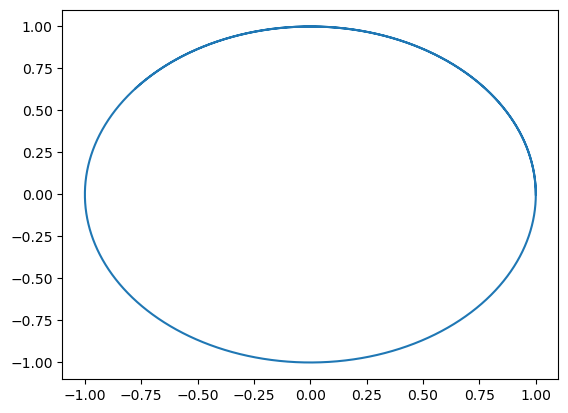

In [8]:
plt.plot(problem.bench.states['NDcartesian'][:,1], problem.bench.states['NDcartesian'][:,2])

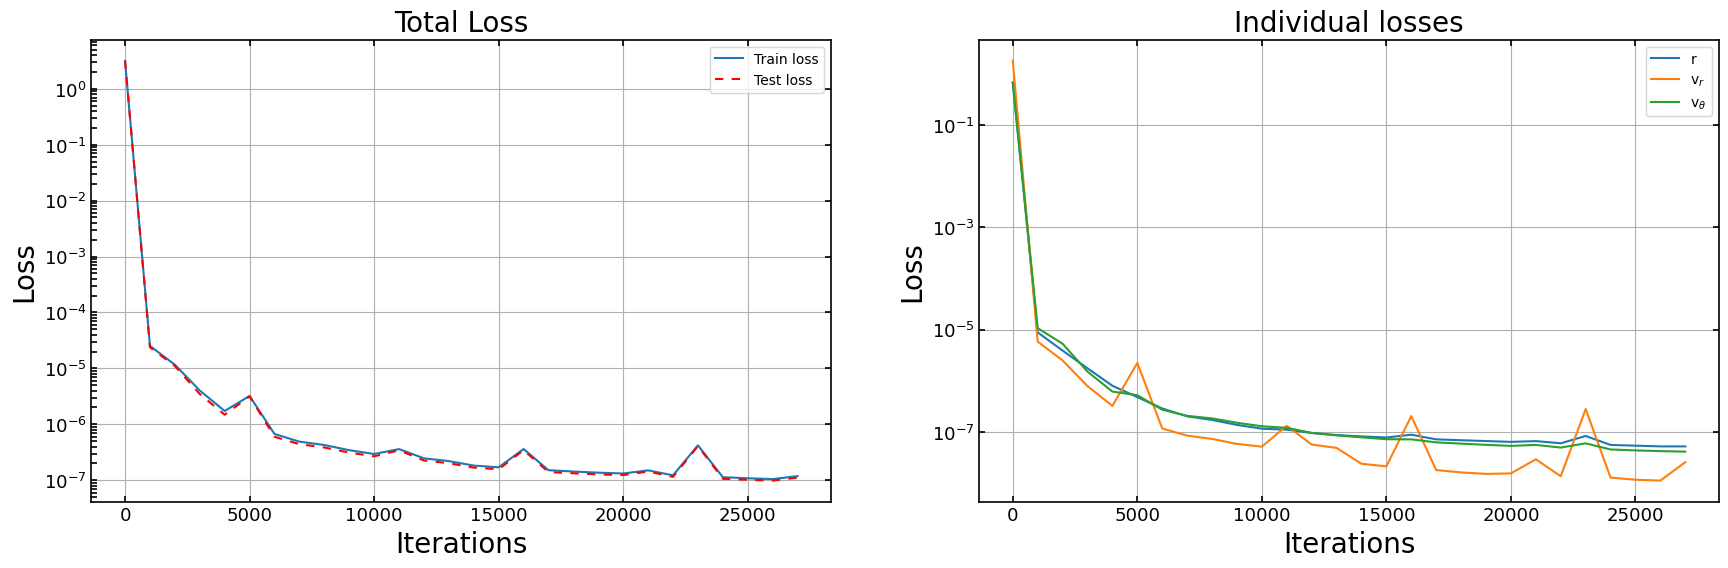

In [11]:
plotting.plot_loss(problem)  
#plotting.plot_transfer(problem)